# Feature Extraction

## Converting Raw .wav files to MFCC

Instead of utilizing the raw audio files as our features we are instead going to utilize Mel-Frequency Cepstral Coefficients. They represent features extracted from an audio signal that capture how humans perceive sound frequencies. This makes them effective
for distinguishing between audio patterns.

Read more about the technical explanation here: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

Read more about the librosa documentation here for feature extraction: https://librosa.org/doc/0.11.0/generated/librosa.feature.mfcc.html 

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
from glob import glob
import os
import json

In [189]:
audio_dir = "../data/raw/"  # directory containing audio files
meta_path = "../data/raw/audioMNIST_meta.txt"  # path to the metadata 
num_mfcc = 30  # number of MFCC to extract
n_segments = 1  # how many segements to split audio files
sample_rate = 16000  # sampling rate

In [190]:
file_paths = glob(audio_dir + "**/*.wav", recursive=True)
print(f"Total files: {len(file_paths)}")

Total files: 30000


In [191]:
file_paths.sort()

We are now going to extract the data we need. This includes the MFCC features from each audio file, as well as the corresponding label (the spoken digit). In addition, we will also collect metadata such as the speaker ID and labeled gender.

Including this information is important because we want to avoid training a model that is unintentionally biased toward a particular speaker or demographic group. Given the data available, it's important to ensure our dataset represents a broad and balanced sample of speakers to support fair and generalizable model performance.

In [192]:
def splitSignal(signal, n_segments):
    """
    Splits an 1D audio signal into a defined number of equal segments.
    Data augmentation technique that treats each individual segment as a seperate sample.
    """

    signal_length = len(signal)
    segment_length = int(np.ceil(signal_length / n_segments))  # size that each segment needs to be
    segment_list = []

    for i in range(n_segments):
        start_index = i * segment_length  # starting index of current segment
        end_index = min((i + 1) * segment_length, signal_length)  # end index of current segment
        segment = signal[start_index:end_index]  # grab the segment
        segment_list.append(segment)  # add it to the list of segments

    return segment_list

Processing all this data should take about 2 minutes. 

In [193]:
with open(meta_path, 'r') as mdf:
    metadata = json.load(mdf)

# Make all speakerIDs format `01` to `1` and lowercase 
gender_map = {int(k): v.get("gender", "unknown").lower() for k, v in metadata.items()}

features = []

for fpath in file_paths:
    audio_data, _ = lb.load(fpath, sr=sample_rate)  # samples the .wav file and puts it into time series
    segments = splitSignal(audio_data, n_segments)  # segmentation of the audio data

    speaker_id = int(os.path.basename(fpath).split('_')[1])  # grab speaker data from the filename
    target = int(os.path.basename(fpath).split('_')[0])  # grab target (digit) label from the filename
    gender = gender_map.get(speaker_id)  # grab gender from the speakerID to labeled gender map 

    for seg in segments:
        mfcc = lb.feature.mfcc(y=seg, sr=sample_rate, n_mfcc=num_mfcc)
        mfcc_avg = np.mean(lb.amplitude_to_db(np.abs(mfcc), ref=np.max), axis=1)
        features.append([speaker_id, gender, target] + mfcc_avg.tolist())

In [194]:
columns = ["speaker", "gender", "digit"] + [f"MFCC_{i}" for i in range(num_mfcc)]
df_mfcc = pd.DataFrame(features, columns=columns)

In [195]:
df_mfcc

,speaker,gender,digit,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,...,MFCC_20,MFCC_21,MFCC_22,MFCC_23,MFCC_24,MFCC_25,MFCC_26,MFCC_27,MFCC_28,MFCC_29
0,1,male,0,-2.394659,-20.243196,-29.121820,-28.889526,-35.540359,-40.320438,-36.588161,...,-49.118999,-42.805637,-49.437515,-47.313919,-45.248749,-46.980194,-43.273941,-47.302692,-54.216511,-48.682178
1,1,male,0,-2.671101,-19.750994,-35.992538,-26.346479,-35.490910,-37.231163,-35.289993,...,-48.602798,-45.260052,-51.366112,-46.468651,-47.262112,-43.880634,-53.733131,-50.635662,-51.184223,-46.328381
2,1,male,0,-2.824619,-19.394251,-30.469421,-28.653658,-33.936775,-41.485439,-37.822330,...,-48.747467,-44.650208,-52.143513,-47.146751,-45.592075,-49.386898,-48.519741,-52.189068,-50.144020,-49.969746
3,1,male,0,-2.670557,-20.354351,-30.437328,-29.649643,-37.076927,-41.439442,-39.385536,...,-50.463284,-45.940742,-49.997902,-47.855915,-44.969452,-43.968330,-48.382885,-46.118599,-51.671040,-51.275063
4,1,male,0,-2.981693,-20.437666,-29.783131,-30.629387,-35.344707,-43.808758,-36.124706,...,-46.925968,-45.539513,-50.654224,-51.208645,-48.332798,-47.619923,-52.360397,-47.726894,-50.741161,-50.125256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,60,female,9,-2.125383,-19.870762,-31.463110,-27.908876,-40.927593,-37.607967,-41.966408,...,-49.995117,-44.848686,-46.532223,-43.706852,-41.620899,-48.300686,-46.366974,-50.685551,-52.635796,-45.727116
29996,60,female,9,-1.799621,-17.802505,-30.652721,-27.031181,-34.391754,-39.123924,-41.146084,...,-46.984745,-46.113026,-52.293236,-40.984337,-42.624298,-53.149078,-43.927624,-40.723969,-46.215649,-47.590332
29997,60,female,9,-1.811312,-19.417135,-30.858545,-25.755701,-33.399235,-37.459610,-41.942993,...,-51.887241,-49.579090,-43.682812,-52.031239,-39.860210,-44.837299,-47.507481,-45.641724,-50.620075,-45.651600
29998,60,female,9,-1.950757,-19.688858,-31.471022,-27.451981,-32.876331,-37.348919,-41.736889,...,-51.555332,-40.329823,-44.634735,-44.025372,-45.870056,-41.324867,-47.121323,-44.747269,-50.225941,-45.294147


We now have a complete dataset to use. Since this took a while to fetch lets save it as a `.pkl` to reuse later.

In [196]:
df_mfcc.to_pickle("../data/processed/mfcc_data.pkl")

## Things to consider when training

Through some research I learned that the 0th MFCC is "affected by differences in the overall energy of the spectrum", which basically means the 0th coefficient is related by the loudness of the audio. In practice, we can ignore the 0th coefficient when training models because we do not want our model to care about how loud or quiet an audio is, but instead classify based on other features of the audio. 

Also, since stratified splitting can only be applied on a single column, we can create a combined label by concatenating the digit, gender, and speaker columns. This ensures that each unique combination of class, demographic, and speaker is proportionally represented in both training and test sets, reducing the risk of bias from uneven splits.

## Quick plots

We can two MFCCs for different sets of digits to see how similar or different their relationships are.

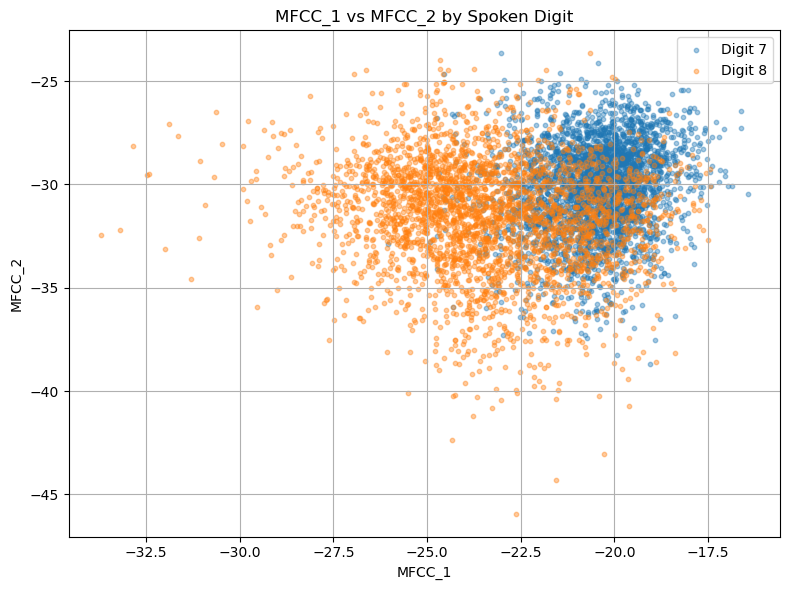

In [197]:
digits_to_plot = [7, 8]  # change this list to filter
x_mfcc = "MFCC_1"
y_mfcc = "MFCC_2"

# Set up the plot
plt.figure(figsize=(8, 6))

# Plot each digit as a different color
for digit in digits_to_plot:
    mask = df_mfcc["digit"] == digit
    plt.scatter(
        df_mfcc.loc[mask, x_mfcc],
        df_mfcc.loc[mask, y_mfcc],
        label=f"Digit {digit}",
        alpha=0.4,
        s=10
    )

plt.xlabel(x_mfcc)
plt.ylabel(y_mfcc)
plt.title(x_mfcc + " vs " + y_mfcc + " by Spoken Digit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can also plot a single MFCC and look at the median, IQR, whiskers, and outliers.

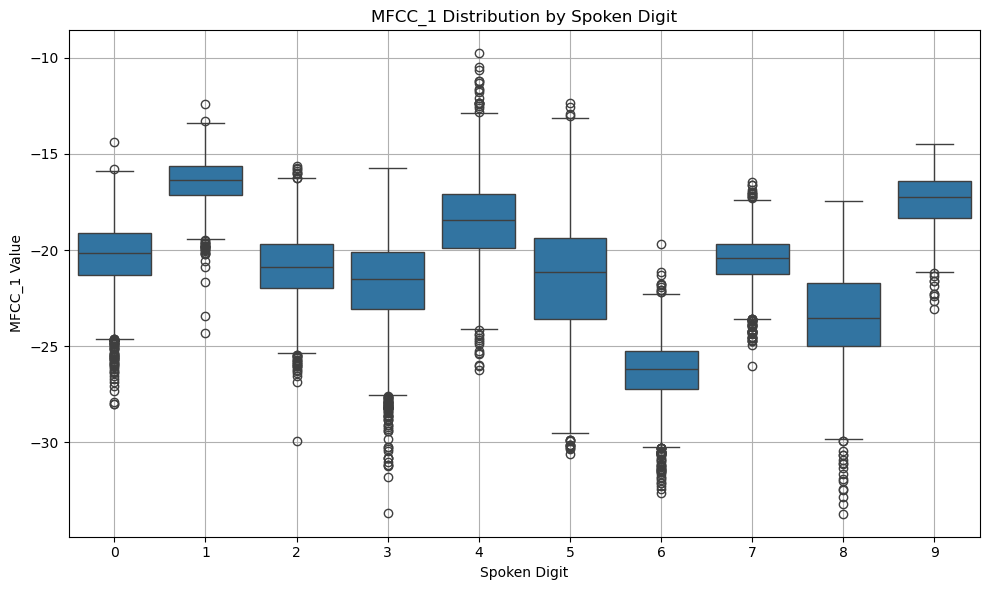

In [198]:
mfcc_col = "MFCC_1"

plt.figure(figsize=(10, 6))
sns.boxplot(x="digit", y=mfcc_col, data=df_mfcc)
plt.title(f"{mfcc_col} Distribution by Spoken Digit")
plt.xlabel("Spoken Digit")
plt.ylabel(f"{mfcc_col} Value")
plt.grid(True)
plt.tight_layout()
plt.show()
